In [2]:
# partial imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler,QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

# imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import plotly.express as pl
import matplotlib.pyplot as plt


# Local imports
import common_paths
import wetter_api as wt
import model_eval as me

# Model Traning

In [3]:
state = "Brandenburg"
parameter_list = [
    wt.DwdObservationParameter.MONTHLY.PRECIPITATION_HEIGHT,
    wt.DwdObservationParameter.MONTHLY.CLIMATE_SUMMARY.WIND_FORCE_BEAUFORT,
    wt.DwdObservationParameter.MONTHLY.TEMPERATURE_AIR_MAX_200,
]

In [4]:
future_bb_weather = pd.read_csv(
    common_paths.DATA.joinpath("dwd/future_Brandenburg.csv")
)
future_bb_weather.drop(columns=["Unnamed: 0", "Bundesland"], inplace=True)
# adjust precipitation to same unit
future_bb_weather["pr"] = future_bb_weather["pr"] * 3600 * 24 * 30
future_bb_weather

,pr,tasmax,sfcWind,Year,Month
0,51.580644,278.43063,4.900000,2024,1
1,54.774196,278.38547,4.761291,2024,1
2,63.967742,278.19840,4.422581,2024,1
3,47.709679,278.55966,4.416129,2024,1
4,47.709679,278.54030,4.367742,2024,1
...,...,...,...,...,...
70390,41.612901,274.10160,4.516129,2054,1
70391,51.967742,273.57257,5.196774,2054,1
70392,51.967742,273.62740,5.316129,2054,1
70393,45.483872,273.60483,5.216129,2054,1


In [5]:
data = me.prepare_data(parameter_list, state)
data

,Year,Month,station_id,pr,sfcWind,tasmax,nFires,area
259,1996,1,00164,0.2,3.384206,275.15,1.0,0.0
260,1996,1,00427,0.7,3.729582,277.45,1.0,0.0
261,1996,1,00650,1.0,2.276450,277.65,1.0,0.0
262,1996,1,00880,2.8,2.746595,280.65,1.0,0.0
263,1996,1,01001,1.4,3.770945,281.15,1.0,0.0
...,...,...,...,...,...,...,...,...
8370,2022,12,03158,37.2,2.897073,290.65,0.0,0.0
8371,2022,12,03376,40.7,2.897073,290.65,0.0,0.0
8373,2022,12,03987,58.8,4.409306,290.45,0.0,0.0
8377,2022,12,05825,45.4,2.897073,289.95,0.0,0.0


In [6]:
test = me.station_means(data)
test_area = test.astype("float").groupby("Year")["area"].sum().reset_index()
test_nr = test.astype("float").groupby("Year")["nFires"].sum().reset_index()
sum = pd.merge(test_area, test_nr, on=["Year"], how="outer")

In [7]:
fig1 = pl.scatter(
    sum,
    x="Year",
    y="area",
    trendline="lowess",
    color_discrete_sequence=["red"],
    title="yearly burned area with trendline in Brandenburg",
    labels={"area": "burned area","Year":"year"},
)
fig2 = pl.scatter(
    sum,
    x="Year",
    y="nFires",
    trendline="lowess",
    color_discrete_sequence=["orange"],
    title="yearly number of fires with trendline in Brandenburg",
    labels={"nFires": "number of fires","Year":"year"},
)
fig1.show()
fig2.show()

Text(0, 0.5, 'number of fires')

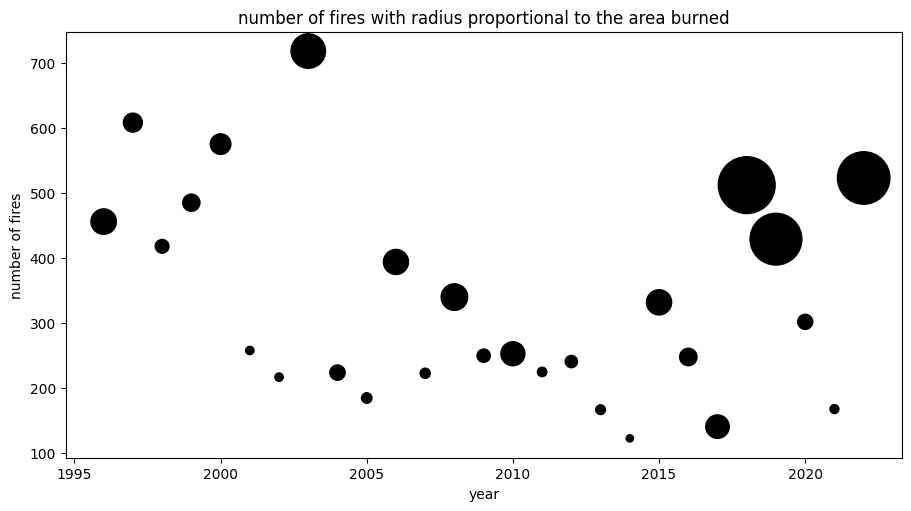

In [8]:
fig, ax = plt.subplots(figsize=(9, 5), layout="constrained")
ax.scatter("Year", "nFires", s="area", data=sum, color="black")

ax.set_title("number of fires with radius proportional to the area burned")
ax.set_xlabel("year")
ax.set_ylabel("number of fires")

In [9]:
fig1 = pl.scatter(
    data,
    x="Month",
    y="area",
    color_discrete_sequence=["red"],
    title="monthly burned area in Brandenburg",
    labels={"area": "burned area","Month":"month"},
)
fig2 = pl.scatter(
    data,
    x="Month",
    y="nFires",
    color_discrete_sequence=["orange"],
    title="monthly number of fires in Brandenburg",
    labels={"nFires": "number of fires", "Month": "month"},
)
fig1.show()
fig2.show()

In [10]:
fig1 = pl.scatter(
    data,
    x="pr",
    y="nFires",
    color_discrete_sequence=["orange"],
    title="number of fires related to precipitation in Brandenburg",
    labels={"nFires": "number of fires", "pr": "precipitation"},
)
fig2 = pl.scatter(
    data,
    x="sfcWind",
    y="nFires",
    color_discrete_sequence=["orange"],
    title="number of fires related to wind speed in Brandenburg",
    labels={"nFires": "number of fires","sfcWind":"wind speed"},
)
fig3 = pl.scatter(
    data,
    x="tasmax",
    y="nFires",
    color_discrete_sequence=["orange"],
    title="number of fires related to maximum temperature in Brandenburg",
    labels={"nFires": "number of fires","tasmax":"maximum temperature"},
)

fig1.show()
fig2.show()
fig3.show()

In [11]:
fig1 = pl.scatter(
    data,
    x="pr",
    y="area",
    color_discrete_sequence=["red"],
    title="burned area related to precipitation in Brandenburg",
    labels={"nFires": "number of fires", "pr": "precipitation", "area": "burned area"},
)
fig2 = pl.scatter(
    data,
    x="sfcWind",
    y="area",
    color_discrete_sequence=["red"],
    title="burned area related to wind speed in Brandenburg",
    labels={
        "nFires": "number of fires",
        "sfcWind": "wind speed",
        "area": "burned area",
    },
)
fig3 = pl.scatter(
    data,
    x="tasmax",
    y="area",
    color_discrete_sequence=["red"],
    title="burned area related to maximum temperature in Brandenburg",
    labels={
        "nFires": "number of fires",
        "tasmax": "maximum temperature",
        "area": "burned area",
    },
)

fig1.show()
fig2.show()
fig3.show()

In [12]:
fig1 = pl.scatter(
    data,
    x="nFires",
    y="area",
    trendline="ols",
    color_discrete_sequence=["black"],
    title="number of fires related to burned area with trendline in Brandenburg",
    labels={"nFires": "number of fires", "area": "burned area"},
)
fig1.show()

<Axes: >

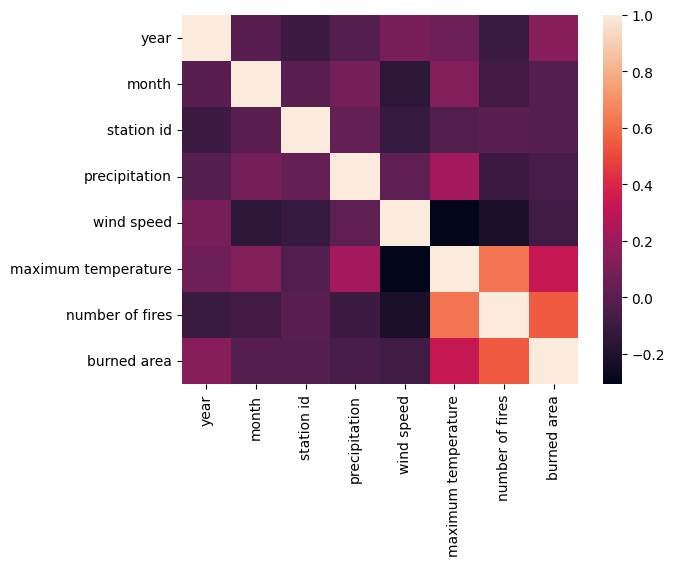

In [32]:
labels = {"nFires": "number of fires", "area": "burned area","pr":"precipitation","sfcWind":"wind speed","tasmax":"maximum temperature","Year":"year","Month":"month","station_id":"station id"}
data_renamed = data.rename(columns=labels)
sb.heatmap(data_renamed.corr(method="pearson", numeric_only=False))

In [14]:
str_parameter_list = [str(param) for param in parameter_list]
dates = data[["Year", "Month"]]
feature_list = ["sfcWind", "pr", "tasmax"]

X_nr = data[feature_list]
y_nr = data["nFires"]

# X, y, dates = shuffle(X, y, dates, random_state=42)
X_train_nr, X_test_nr, y_train_nr, y_test_nr, dates_train, dates_test = (
    train_test_split(X_nr, y_nr, dates, test_size=0.2, random_state=42)
)

In [15]:
X_scaled_train = RobustScaler().fit_transform(X_train_nr)
X_scaled_test = RobustScaler().fit_transform(X_test_nr)

In [16]:

quantile_transformer = QuantileTransformer(random_state=0)
X_train_trans = quantile_transformer.fit_transform(X_scaled_train)
X_test_trans = quantile_transformer.transform(X_scaled_test)

In [17]:

param_grid = {
    "n_estimators": [70, 80, 100],
    "max_depth": [3, 5, 6],  # Smaller range for max depth
    "min_samples_leaf": [2, 3, 5],
    "min_samples_split": [5, 7, 8],
}
gbr = GradientBoostingRegressor()
cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(
    estimator=gbr, param_grid=param_grid, cv=cv, scoring="neg_mean_squared_error"
)
# searching for the right parameters using random Forest on a 5-fold Cross Validation (cv) and the nmse
nr_grid = grid_search.fit(X_scaled_train, y_train_nr)

# saving best parameters and model
nr_best_params = grid_search.best_params_
nr_best_model = grid_search.best_estimator_
print(nr_best_params)
print(nr_best_model)

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80}
GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=8,
                          n_estimators=80)


In [18]:
# predict 'Anzahl Waldbrände' with the model
y_pred_nr = nr_best_model.predict(X_scaled_test)


mse = mean_squared_error(y_test_nr, y_pred_nr)
r2 = r2_score(y_test_nr, y_pred_nr)
mae = mean_absolute_error(y_test_nr, y_pred_nr)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")
print(f"MAE: {mae}")

MSE: 839.0949139553289
R2 Score: 0.5687712234666384
MAE: 16.340470609155776


# Visualisation

In [19]:
# imports
import matplotlib.pyplot as plt
import pandas as pd

# local imports
import common_paths

In [20]:
df_number = pd.read_csv(common_paths.DATA.joinpath("dwd/nr_Brandenburg.csv"))
df_area = pd.read_csv(common_paths.DATA.joinpath("dwd/area_Brandenburg.csv"))
df_predict = pd.read_csv(common_paths.DATA.joinpath("dwd/final_predictions.csv"))
df_predict["time_in_months"] = df_predict["Year"] + (df_predict["Month"] - 1) / 12

df_number["time_in_months"] = df_number["Year"] + (df_number["Month"] - 1) / 12
df_area["time_in_months"] = df_area["Year"] + (df_area["Month"] - 1) / 12
df_hist = df_number.merge(
    df_area[["Year", "Month", "area"]], on=["Year", "Month"], how="left"
)
df_hist = df_hist[df_hist["Year"] > 1995]

In [21]:
df_predict.drop(columns=["Unnamed: 0"], inplace=True)
df_predict

,Year,Month,tasmax,sfcWind,pr,area_predictions,nr_predictions,time_in_months
0,2024,1,277.818281,4.376295,51.553847,0.270256,0.211310,2024.000000
1,2024,2,275.542922,3.763572,13.482759,4.274414,1.237931,2024.083333
2,2024,3,282.054063,4.178627,21.255087,0.308581,0.261001,2024.166667
3,2024,4,290.934900,3.595162,20.208205,12.300988,12.345164,2024.250000
4,2024,5,294.976148,2.951547,47.807941,5.022404,8.041631,2024.333333
...,...,...,...,...,...,...,...,...
356,2053,9,295.810764,2.768496,16.893846,21.231409,47.769851,2053.666667
357,2053,10,285.987099,3.775451,48.880397,0.270256,0.274363,2053.750000
358,2053,11,278.810097,3.910427,76.919488,0.270256,0.211310,2053.833333
359,2053,12,272.485429,3.304169,27.871464,0.270256,0.211310,2053.916667


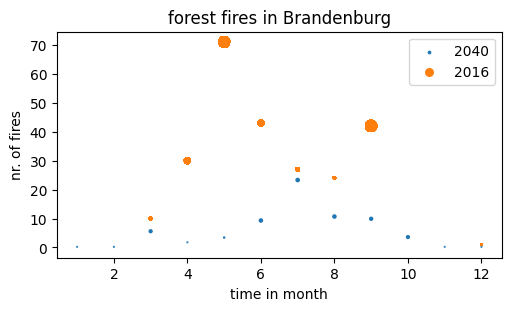

In [22]:
def compare_years(df_hist, df_predict, year_hist, year_future):
    if year_hist < 1996 or year_hist > 2022:
        print("Error: Historical dates range only from 1996 to 2022")
        return
    if year_future < 2024 or year_future > 2053:
        print("Error: Prediction dates range only from 2024 to 2053")
        return
    df_hist_year = df_hist[df_hist["Year"] == year_hist]
    df_predict_year = df_predict[df_predict["Year"] == year_future]

    fig, ax = plt.subplots(figsize=(5, 3), layout="constrained")
    ax.scatter(
        "Month",
        "nr_predictions",
        s="area_predictions",
        data=df_predict_year,
        label=year_future,
    )
    ax.scatter("Month", "nFires", s="area", data=df_hist_year, label=year_hist)
    ax.set_title("forest fires in Brandenburg")
    ax.set_xlabel("time in month")
    ax.set_ylabel("nr. of fires") 
    ax.legend()


compare_years(df_hist, df_predict, 2016, 2040)

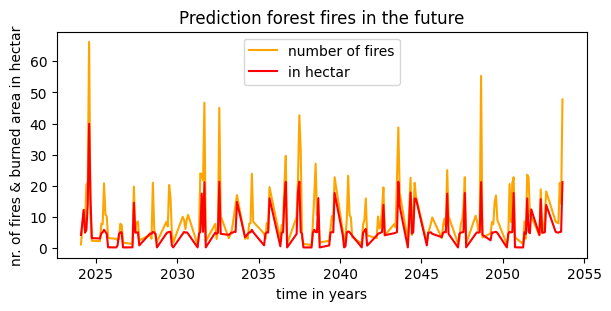

In [23]:
df_predict_nozero = df_predict[df_predict["nr_predictions"] > 1]
df_predict_nozero = df_predict_nozero[df_predict_nozero["area_predictions"] > 0.1]
fig, ax = plt.subplots(figsize=(6, 3), layout="constrained")
ax.plot("time_in_months", "nr_predictions", data=df_predict_nozero, label="number of fires",color="orange")
ax.plot(
    "time_in_months", "area_predictions", data=df_predict_nozero, label="in hectar",color="red"
)
ax.set_title("Prediction forest fires in the future")
ax.set_xlabel("time in years")
ax.set_ylabel("nr. of fires & burned area in hectar")
ax.legend()
plt.show()

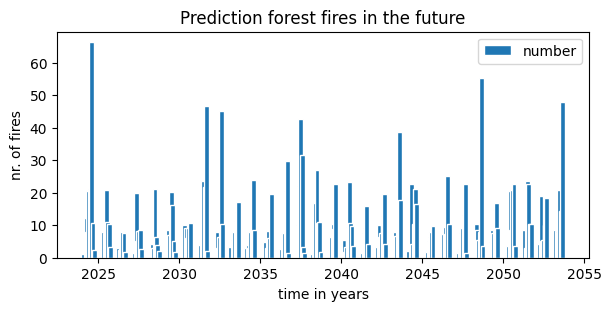

In [24]:
df_predict_nozero = df_predict[df_predict["nr_predictions"] > 1]
df_predict_nozero = df_predict_nozero[df_predict_nozero["area_predictions"] > 0.1]
fig, ax = plt.subplots(figsize=(6, 3), layout="constrained")
ax.bar(
    "time_in_months",
    "nr_predictions",
    data=df_predict_nozero,
    label="number",
    edgecolor="white",
    width=0.3,
)
ax.set_title("Prediction forest fires in the future")
ax.set_xlabel("time in years")
ax.set_ylabel("nr. of fires")
ax.legend()
plt.show()

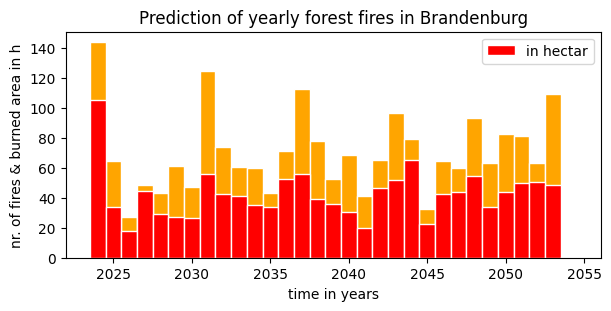

In [25]:
df_predict_avg = (
    df_predict.groupby("Year")[["nr_predictions", "area_predictions"]]
    .sum()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(6, 3), layout="constrained")
ax.bar(
    "Year",
    "nr_predictions",
    data=df_predict_avg,
    edgecolor="white",
    width=1,
    color="orange",
)
ax.bar(
    "Year",
    "area_predictions",
    data=df_predict_avg,
    label="in hectar",
    width=1,
    edgecolor="white",
    color="red",
)
ax.set_title("Prediction of yearly forest fires in Brandenburg")
ax.set_xlabel("time in years")
ax.set_ylabel("nr. of fires & burned area in h")
ax.legend()
plt.show()

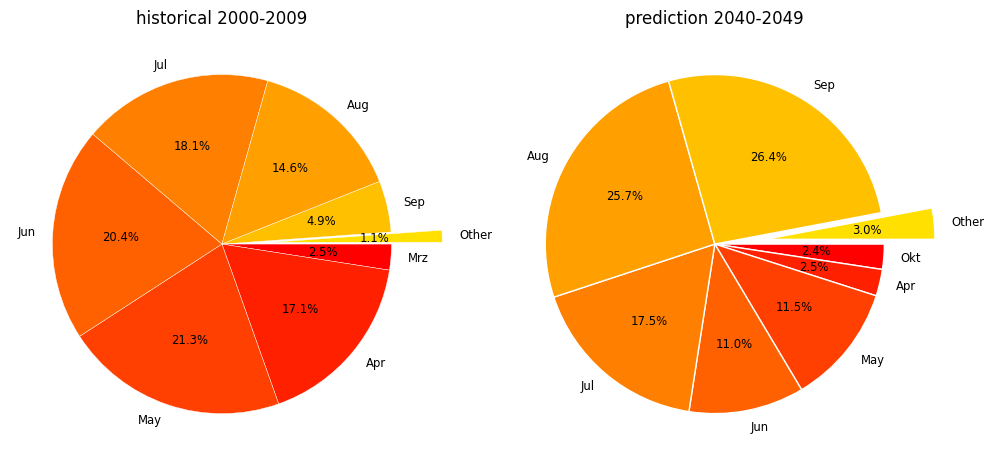

In [26]:
# data compare Months
# 2000 - 2009
df_2000 = df_hist[(df_hist["Year"] > 1999) & (df_hist["Year"] < 2010)]
df_2000 = df_2000.groupby("Month")[["nFires", "area"]].mean().reset_index()

df_2040 = df_predict[(df_predict["Year"] > 2039) & (df_predict["Year"] < 2050)]
df_2040 = (
    df_2040.groupby("Month")[["nr_predictions", "area_predictions"]]
    .mean()
    .reset_index()
)


# Combine Month with very low nr to Other
df_2040["Month"] = df_2040["Month"].apply(
    lambda x: (
        "Other"
        if df_2040.loc[df_2040["Month"] == x, "nr_predictions"].values[0] < 1.2
        else str(x)
    )
)
df_2040 = (
    df_2040.groupby("Month")[["nr_predictions", "area_predictions"]].sum().reset_index()
)


df_2000["Month"] = df_2000["Month"].apply(
    lambda x: (
        "Other"
        if df_2000.loc[df_2000["Month"] == x, "nFires"].values[0] < 2.6
        else str(x)
    )
)
df_2000 = df_2000.groupby("Month")[["nFires", "area"]].sum().reset_index()


cmap_2000 = plt.get_cmap("winter")
cmap_2040 = plt.get_cmap("autumn")

# map colors
colors_2000 = [cmap_2000(i / len(df_2000)) for i in range(len(df_2000))]
colors_2040 = [cmap_2040(i / len(df_2040)) for i in range(len(df_2040))]

# hardcoded right labels
labels_2040 = "Okt", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Other"
labels_2000 = "Mrz", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Other"

# explode Other
ax1explode = [0.3 if label == "Other" else 0 for label in df_2040["Month"]]
ax2explode = [0.3 if label == "Other" else 0 for label in df_2040["Month"]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.pie(
    "nFires",
    data=df_2000,
    autopct="%1.1f%%",
    explode=ax1explode,
    textprops={"size": "smaller"},
    wedgeprops={"linewidth": 0.3, "edgecolor": "white"},
    frame=False,
    colors=colors_2040,
    labels=labels_2000,
    startangle=0,
    counterclock=False,
)
ax1.set_title("historical 2000-2009")
ax2.pie(
    "nr_predictions",
    data=df_2040,
    autopct="%1.1f%%",
    explode=ax2explode,
    textprops={"size": "smaller"},
    wedgeprops={"linewidth": 1, "edgecolor": "white"},
    frame=False,
    colors=colors_2040,
    labels=labels_2040,
    counterclock=False,
)
ax2.set_title("prediction 2040-2049")

# fig.suptitle("Monthly forest fires")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'number of fires')

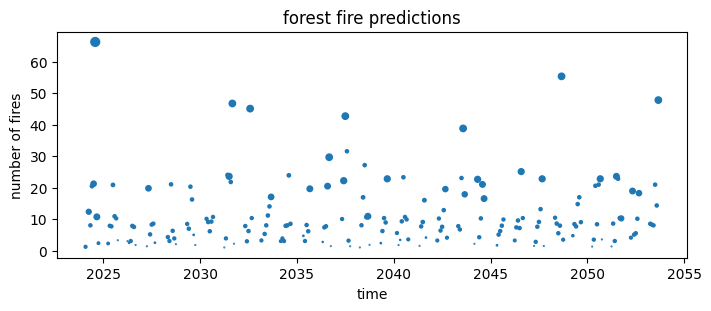

In [27]:
df_predict_nozero = df_predict[df_predict["nr_predictions"] > 1]
fig, ax = plt.subplots(figsize=(7, 3), layout="constrained")
ax.scatter(
    "time_in_months", "nr_predictions", s="area_predictions", data=df_predict_nozero
)
ax.set_title("forest fire predictions")
ax.set_xlabel("time")
ax.set_ylabel("number of fires")